In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
from sklearn.model_selection import KFold
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1':'1 Fam Rew', 
             'Task2':'2 No Rew No Lick', 
             'Task3':'3 Fam Rew', 
             'Task4':'4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'

frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 129
Number of PlaceCells in Task1 is 133
Number of PlaceCells in Task3 is 123
Number of PlaceCells in Task4 is 119
Number of PlaceCells in Task2a is 129


### Control Data

In [6]:
# Get Xdata - calcium data and Ydata - running behavior
X = A.Fc3data_dict['Task1'][:, A.Parsed_Behavior['good_running_index'].item()['Task1']].T[:11000, :]
Y = A.Parsed_Behavior['good_running_data'].item()['Task1'][:11000]
X, Y = equalise_laps_with_numlaps_innorew(A, X, Y, 'Task1', laps_current=, numlaps_topick, E_correction=1,
                                           lapcorrectionflag=0, figureflag=1)
print('Lap Corrected', np.shape(X), np.shape(Y))

(12298, 316) (12298, 1)


NameError: name 'pred' is not defined

In [ ]:
B = PreBeh(BehaviorData=Y, tracklength=tracklength, trackbins=trackbins)
y_cat = B.position_binary

### No Rew Data

In [14]:
# Get Xdata - calcium data and Ydata - running behavior
X_Norew = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew = A.Parsed_Behavior['good_running_data'].item()['Task2']
print('Total shape:', np.shape(X_Norew), np.shape(Y_Norew))

#Keep frames after lick stops in no reward condition
X_Norew, Y_Norew = pred.get_frames_afterlickstops(Imgobj=A, X_norew=X_Norew, Y_norew=Y_Norew)
print('After lick stops:', np.shape(X_Norew), np.shape(Y_Norew))

Total shape: (8067, 304) (8067, 1)
After lick stops: (6973, 304) (6973, 1)


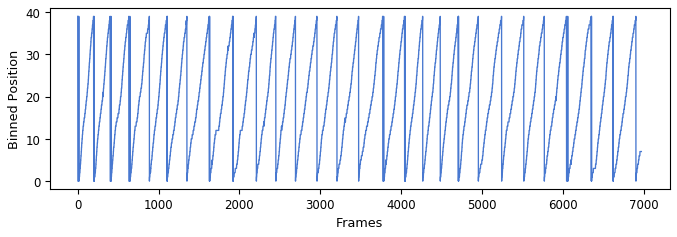

In [15]:
B = pbd(BehaviorData=Y_Norew, tracklength=tracklength, trackbins=trackbins, trackstart_index=1)
y_cat_norew = B.position_binary

### Reward2 data

In [13]:
# Get Xdata - calcium data and Ydata - running behavior
X_rew2 = A.Fc3data_dict['Task3'][:, A.Parsed_Behavior['good_running_index'].item()['Task3']].T
Y_rew2 = A.Parsed_Behavior['good_running_data'].item()['Task3']
print(np.shape(X_rew2), np.shape(Y_rew2))


(6620, 304) (6620, 1)
Number of laps being chosen 27


ValueError: n_population should be greater or equal than n_samples, got n_samples > n_population (27 > 19)

In [ ]:
B = pbd(BehaviorData=Y_rew2, tracklength=tracklength, trackbins=trackbins)
y_cat_rew2 = B.position_binary

### Novel Data

In [ ]:
# Get Xdata - calcium data and Ydata - running behavior
X_nov = A.Fc3data_dict['Task4'][:, A.Parsed_Behavior['good_running_index'].item()['Task4']].T
Y_nov = A.Parsed_Behavior['good_running_data'].item()['Task4']
print(np.shape(X_nov), np.shape(Y_nov))
X_nov, Y_nov = pred.equalise_laps_with_numlaps_innorew(A, X_nov, Y_nov, 'Task4')
print('Lap Corrected', np.shape(X_nov), np.shape(Y_nov))

In [ ]:
B = pbd(BehaviorData=Y_nov, tracklength=tracklength, trackbins=trackbins)
y_cat_nov = B.position_binary

## Run Bayes on each data seperately 

In [ ]:
X_data = [X, X_Norew, X_rew2, X_nov]
Y_data = [y_cat, y_cat_norew, y_cat_rew2, y_cat_nov]
TaskName = task_dict.keys()

In [ ]:
for x, y, t in zip(X_data, Y_data, TaskName):
    print('Decoding...', task_dict[t])
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=None, shuffle=False)
    print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))
    gaussianNB = nb.fit_naivebayes(X_train, y_train)
    scores, y_predicted, y_errorprob = nb.validate_model(gaussianNB, X_test, y_test)
    m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
    R2 = m.get_R2(y_test, y_predicted)
    rho = m.get_rho(y_test, y_predicted)
    print(f'R2: %.2f' %R2)
    print(f'rho: %.2f\n\n' %rho)

## Prediction accuracy with number of cells for all tasks

### Control data

In [ ]:
numsamples, R2_numcells_dict_cntrl, rho_numcells_dict_cntrl = nb.decoderaccuracy_wtih_numcells(X_data=X, Y_data=y_cat, iterations=100)

In [ ]:
mean_R2_cntrl, sem_R2_cntrl = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_cntrl, numsamples)

### No reward data

In [ ]:
numsamples, R2_numcells_dict_norew, rho_numcells_dict_norew = nb.decoderaccuracy_wtih_numcells(X_data=X_Norew, Y_data=y_cat_norew, iterations=100)

In [ ]:
mean_R2_norew, sem_R2_norew = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_norew, numsamples)

### Reward2 data

In [ ]:
numsamples, R2_numcells_dict_rew2, rho_numcells_dict_rew2 = nb.decoderaccuracy_wtih_numcells(X_data=X_rew2, Y_data=y_cat_rew2, iterations=100)

In [ ]:
mean_R2_rew2, sem_R2_rew2 = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_rew2, numsamples)

### Novel Data

In [ ]:
numsamples, R2_numcells_dict_nov, rho_numcells_dict_nov = nb.decoderaccuracy_wtih_numcells(X_data=X_nov, Y_data=y_cat_nov, iterations=100)

In [ ]:
mean_R2_nov, sem_R2_nov = nb.plot_decoderaccuracy_with_numcells(R2_numcells_dict_nov, numsamples)

### Plot it all together

In [ ]:
plt.figure(figsize=(5, 3), dpi=100)
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_cntrl, yerr=sem_R2_cntrl, color='b', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='Control')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_norew, yerr=sem_R2_norew, color='g', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='Without Reward')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_rew2, yerr=sem_R2_rew2, color='r', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='With Reward2')
plt.errorbar(np.arange(np.size(numsamples)), mean_R2_nov, yerr=sem_R2_nov, color='purple', fmt='o-', ecolor='k', capthick=5, linewidth=2, label='Novel')

plt.xticks(np.arange(np.size(numsamples)), ['10%', '20%', '50%', '80%', '100%'])
plt.xlabel('Percentage of cells used')
plt.ylabel('Decoding accuracy');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))